In [2]:
import iris
import numpy as np
from iris import quickplot as qplt
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from mogreps_utils import list_files, unrotate, get_uk_from_global, get_info, get_ground_level

In [4]:
g_files = list_files('mogreps-g', 'prods_op_mogreps-g_20160207_00_01', 10000)
uk_files = list_files('mogreps-uk', 'prods_op_mogreps-uk_20160207_03_01', 10000)

In [175]:
len(g_files)

58

In [6]:
variable = 'relative_humidity'

In [7]:
def blitz(cube):
    cube.var_name = cube.standard_name
    for c in cube.aux_coords:
        c.var_name = c.standard_name

In [8]:
def get_uk_global_pairs(param, uk_files, g_files, blat, blon, uk_path='../data/mogreps-uk/', g_path='../data/mogreps-gg/'):
    '''Return two CubeLists of matching UK and global cubes, each containing one timestep, for the given param.'''
    uks = iris.cube.CubeList([])
    gs = iris.cube.CubeList([])
    
    stash = iris.load(uk_path + uk_files[0], param)[0].attributes['STASH'].__str__()
    stash_const = iris.AttributeConstraint(STASH=stash)
    
    for fname in uk_files:
        info = get_info(fname)
        uk_fname = fname
        g_fname = 'prods_op_mogreps-g_{}_{:02d}_{:02d}_{:03d}.nc'.format(info[0], info[1]-3, info[2], info[3]+3)

        if g_fname in g_files:
            try:
                g_cube = iris.load(g_path + g_fname, stash_const)[0]
                uk_cube = iris.load(uk_path + uk_fname, stash_const)[0]
                
                time_constraint = iris.Constraint(time=uk_cube.coord('time').points[-1])
                g_cube = g_cube.extract(time_constraint)
                uk_cube = uk_cube.extract(time_constraint)
                
                uk_cube, uk_h = get_ground_level(uk_cube)
                if uk_h: uk_cube.remove_coord(uk_h)
                g_cube, g_h = get_ground_level(g_cube)
                if g_h: g_cube.remove_coord(g_h)
                    
                uk_unrotate = unrotate(uk_cube, g_cube)
#                 g_cube_uk = get_uk_from_global(g_cube, uk_unrotate)
                uk_unrotate = uk_unrotate.intersection(latitude=blat, longitude=blon)
                g_cube = g_cube.intersection(latitude=blat, longitude=blon)

                blitz(uk_unrotate)
                blitz(g_cube)
                
                uks.append(uk_unrotate)
                gs.append(g_cube)
            except (IndexError, AttributeError):
                pass
    return (uks, gs)

In [9]:
%%time 
uks, gs = get_uk_global_pairs(variable, uk_files, g_files, blat=(57, 58), blon=(0,1))

/opt/conda/lib/python3.5/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


CPU times: user 9.04 s, sys: 104 ms, total: 9.14 s
Wall time: 1min 31s


In [10]:
scheme=iris.analysis.Nearest()

In [11]:
%%time
uks_regrid = iris.cube.CubeList([uks[i].regrid(grid=gs[i], scheme=scheme) for i in range(len(uks))])

CPU times: user 424 ms, sys: 12 ms, total: 436 ms
Wall time: 19.4 s


In [12]:
uks_regrid_c = uks_regrid.merge_cube()
gs_c = gs.merge_cube()

uks_regrid_c.remove_coord('forecast_period')
gs_c.remove_coord('forecast_period')

In [13]:
diff = uks_regrid_c - gs_c

In [14]:
diff.collapsed(['latitude', 'longitude'], iris.analysis.RMS).data

/opt/conda/lib/python3.5/site-packages/iris/cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


array([ 25.14572144,   2.90787363,  22.10586548,  21.61476135,
        30.63962173,   9.65525532,  14.32545853,  19.3157692 ,
        20.48760986,  11.75077629,  10.76537132,  21.20509911], dtype=float32)

In [15]:
i = -1

0


/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


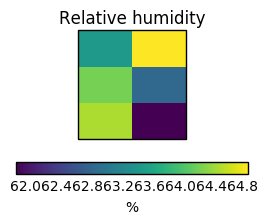

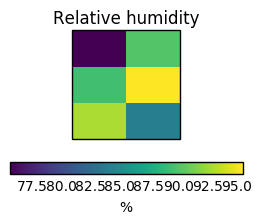

In [16]:
i += 1
print(i)
plt.figure(figsize=(3,2))
qplt.pcolormesh(gs[i], cmap='viridis')
plt.figure(figsize=(3,2))
qplt.pcolormesh(uks_regrid[i], cmap='viridis')

In [17]:
import GPy

In [19]:
# K = GPy.kern.RBF(1)
# icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=1,kernel=K)

In [271]:
g_input = gs_c.data.reshape(12, 6, 1)[:10, 0]
uk_output = uks_regrid_c.data.reshape(12, 6, 1)[:10, 0]

In [272]:
# g_input = [gs_c.data.reshape(12, 6)[:10, :] for _ in range(6)]
# uk_output = [uks_regrid_c.data.reshape(12, 6, 1)[:10, i] for i in range(6)]

In [273]:
np.array(g_input).shape

(10, 1)

In [274]:
np.array(uk_output).shape

(10, 1)

In [236]:
# k = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
# icm = GPy.util.multioutput.ICM(input_dim=6, num_outputs=6, kernel=k)
# m = GPy.models.GPCoregionalizedRegression(g_input, uk_output, kernel=icm)

In [276]:
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(g_input,uk_output,k)

In [277]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [278]:
m.optimize(messages=True)

In [279]:
m

GP_regression.,value,constraints,priors
rbf.variance,8278.2895293,+ve,
rbf.lengthscale,208.799559752,+ve,
Gaussian_noise.variance,81.8980046903,+ve,


In [283]:
gs_c.data.reshape(12, 6, 1)[11:, 0]

array([[ 71.5]], dtype=float32)

In [248]:
m.plot?

 /opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


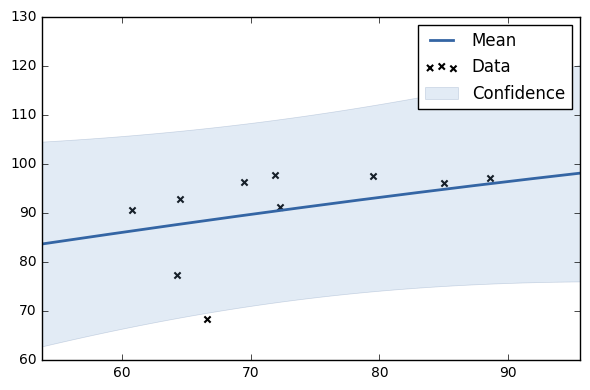

In [280]:
m.plot()

In [284]:
m.predict(gs_c.data.reshape(12, 6, 1)[11:, 0])

(array([[ 90.30137873]]), array([[ 90.1473289]]))

In [285]:
uks_regrid_c.data.reshape(12, 6, 1)[11:, 0]

array([[ 98.125]], dtype=float32)

In [287]:
g_input = [gs_c.data.reshape(12, 6)[:10, :] for _ in range(6)]
uk_output = [uks_regrid_c.data.reshape(12, 6, 1)[:10, i] for i in range(6)]

In [302]:
np.array(g_input).shape

(6, 10, 6)

In [461]:
k = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
icm = GPy.util.multioutput.ICM(input_dim=6, num_outputs=6, kernel=k)
m = GPy.models.GPCoregionalizedRegression(g_input, uk_output, kernel=icm)

In [462]:
m

gp.,value,constraints,priors
ICM.rbf.variance,1.0,+ve,
ICM.rbf.lengthscale,1.0,+ve,
ICM.B.W,"(6, 1)",,
ICM.B.kappa,"(6,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1.0,+ve,
mixed_noise.Gaussian_noise_1.variance,1.0,+ve,
mixed_noise.Gaussian_noise_2.variance,1.0,+ve,
mixed_noise.Gaussian_noise_3.variance,1.0,+ve,
mixed_noise.Gaussian_noise_4.variance,1.0,+ve,
mixed_noise.Gaussian_noise_5.variance,1.0,+ve,


In [499]:
m.optimize()

In [500]:
m

gp.,value,constraints,priors
ICM.rbf.variance,35.0687806528,+ve,
ICM.rbf.lengthscale,0.609973492464,+ve,
ICM.B.W,"(6, 1)",,
ICM.B.kappa,"(6,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.0679913338901,+ve,
mixed_noise.Gaussian_noise_1.variance,2.46343619791,+ve,
mixed_noise.Gaussian_noise_2.variance,1.02457122802,+ve,
mixed_noise.Gaussian_noise_3.variance,0.124731655288,+ve,
mixed_noise.Gaussian_noise_4.variance,0.0914896894761,+ve,
mixed_noise.Gaussian_noise_5.variance,0.015468346762,+ve,


In [422]:
tst = gs_c.data.reshape(12, 6)[11:, :].repeat(6,0)

In [434]:
t = np.array([[tst[i].tolist(), i] for i in range(tst.shape[0])])

In [481]:
gs_c.data.reshape(12, 6)[11]

array([ 71.5  ,  77.125,  72.125,  75.125,  72.625,  73.375], dtype=float32)

In [489]:
[np.hstack((gs_c.data.reshape(12, 6)[0], np.array([i]))) for i in range(6)]

[array([ 64.5  ,  61.875,  64.25 ,  62.875,  63.5  ,  64.875,   0.   ]),
 array([ 64.5  ,  61.875,  64.25 ,  62.875,  63.5  ,  64.875,   1.   ]),
 array([ 64.5  ,  61.875,  64.25 ,  62.875,  63.5  ,  64.875,   2.   ]),
 array([ 64.5  ,  61.875,  64.25 ,  62.875,  63.5  ,  64.875,   3.   ]),
 array([ 64.5  ,  61.875,  64.25 ,  62.875,  63.5  ,  64.875,   4.   ]),
 array([ 64.5  ,  61.875,  64.25 ,  62.875,  63.5  ,  64.875,   5.   ])]

In [490]:
m.predict(np.array([np.hstack((gs_c.data.reshape(12, 6)[0], np.array([i]))) for i in range(6)]), include_likelihood=False)

(array([[ 92.99838711],
        [ 84.21780346],
        [ 89.60927457],
        [ 95.4354543 ],
        [ 75.73775333],
        [ 90.11748954]]), array([[ 0.01235194],
        [ 0.71843   ],
        [ 0.79622947],
        [ 0.57328086],
        [ 0.6640869 ],
        [ 0.03915602]]))

In [491]:
np.array(uks_regrid_c.data.reshape(12, 6))[11]

array([ 98.125,  98.125,  91.125,  97.75 ,  88.75 ,  93.75 ], dtype=float32)

 /opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


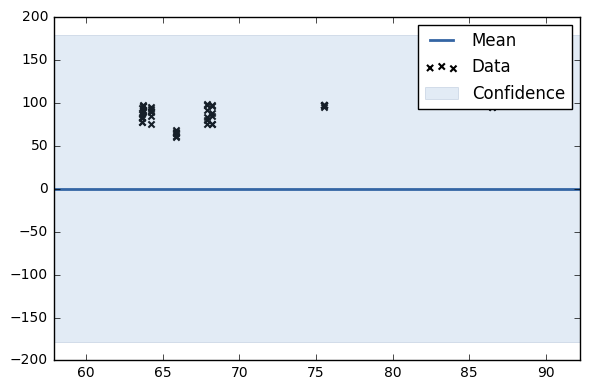

In [494]:
m.plot(visible_dims=[2])